# Model B: Vision Transformer for Classifying Potato Diseases

This notebook contains our solution using the approach:
    - Deep learning based approaches underpinned by transformer architechtures

Our approach used Vision Transformer and created the model from scratch to follow the "Closed Mode" principle


## Methodology
Our methodology for this project involves the following steps:

### 1. Setup the Random Seed
We set the random seed to 42, which is for reproducibility. The values could be edited to a different value which would not affect the performance of the model and would not cause overfitting
### 2. Set up proper CPU/GPU dependencies
Using GPU is much better in terms of performance, training time, and it would safekeep hardware, while using CPU will be much more slower and also might fry your CPU, thus the need for GPU to be used
### 3. Preprossesing the Images
Cleaning the dataset by resizing the images to 288 x 288 pixels and normalizing it to the Image.net values for normalization. For the Train Data, we used random Crop, random horizontalflip, random verticalflip, random rotation, color jitter, and gaussian blur to avoid overfitting and make the model not memorize the data. For the validation data, no augmentations will be done.
We used an 80 - 20 split for the train - validation, from the dataset, as the the test data will come at a later stage of this project.
### 4. Building the Model
Our model follows the traditional ViT model from the lessons, we build it from scratch. The model consists of a patch embedding layer instead of convolutional layer, where its purpose is to split the image into patches. We also have class token and position embedding which retain spatial information and handles the patch sequence. Next is the transformer layer which processes and learns the image. Lastly, the mlp Classification head handles the classification. The last two layers contain dropouts to handle overfitting and uses GELU
### 5. Training the Model
Training the model, we used 200 epochs since training ViT models from scratch needs alot of epochs to learn. ViT also needs alot of dataset, but currently we have very little which is why the 200 epoch and patience will be high. Per epoch, validity accuracy and loss, as well as train accuracy and loss is printed to check for overfitting and plateus for manual stopping
### 6. Evaluating the Model
Evaluatiung the model through accuracy, F1 scores, stabiility, recall and specificity per class is printed at the end of this notebook. With this evaluation we are able to evaluate the performance of the model per class, knowing which class has a harder time to recognize by the model. Evaluating also includes the graph for the Train vs Validity values aswell as the confusion matrices, which finds overfitting and find the models confusion between classes.
### 7. Prediction using Test Dataset
After, using the test dataset, the model is used to predict this dataset, which is saved at the deeplearning_vit_predictions.csv file, with also evaluation on how it accuractely classifies potato diseases

We tried finetuning our model but the accuracy of our model stays the same and no improved performance is shown by fine-tuning it to recommended parameters and ways.

## Other methods we tried
### 1. Fine Tuning using Hybrid Model from our current model and the vit_base_patch model with pretrained = false:

This is what we used for finetuning but the learning still plateu at the same accuracy with the original model we have. We also tried getting the weights but still same performance

### 2. Use of Mix-ups:

Made the performance worse and shows severe overfitting, even with lots of dropouts

### 3. Using CNN then using ViT:
Much lesser performance than the current model

### 4. From the dataset duplicating them to RGB, HSV, YCbCR, GrayScale, and increasing the contrast making our dataset times 5
This gave a good accuracy from the model, but it learned the wrong features which when used in the prediction from the test dataset, it is much worse from the current model we have

# Imports

In [18]:

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
from tqdm import tqdm
import timeit
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


# Set fixed random seed for reproducibility

In [19]:
def set_seed(seed=42):
    random.seed(seed)                      # Python random module
    np.random.seed(seed)                   # NumPy
    torch.manual_seed(seed)                # PyTorch CPU
    torch.cuda.manual_seed(seed)           # PyTorch GPU
    torch.cuda.manual_seed_all(seed)       # PyTorch multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check and ensure proper GPU Dependencies

In [20]:
# Check CPU/GPU dependencies
torch.cuda.empty_cache()

print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Cached memory:    {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# Run the code using the GPU; caution: might burn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Allocated memory: 2255.38 MB
Cached memory:    2330.00 MB
Using device: cuda


# Configuration of Parameters

In [21]:
EPOCHS = 200
BATCH_SIZE = 32  
IMG_SIZE = 224 + 96
PATCH_SIZE = 16
IN_CHANNELS = 3
EMBED_DIM = 256
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
NUM_HEADS = 8
NUM_ENCODERS = 6
NUM_CLASSES = 6
LEARNING_RATE = 1e-4 
DROPOUT = 0.1
ACTIVATION = 'gelu'
WARMUP_EPOCHS = 5  


# Data Augmentation and Preprocessing


In [22]:
transform = transforms.Compose([
   transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomCrop(IMG_SIZE, padding=32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 0.5)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.7, scale=(0.05, 0.2))
])



# Splitting and Loading the Data

In [23]:
dataset_root = "potato_train"
# Load the full dataset with training transformations
full_dataset = datasets.ImageFolder(root=dataset_root, transform=transform)
targets = [label for _, label in full_dataset.samples]
print("Class to index mapping:", full_dataset.class_to_idx)
print("Label distribution:", Counter(targets))


splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(full_dataset, val_idx)

# Apply transforms

# ✅ Compute class weights from stratified training labels
train_labels = [targets[i] for i in train_idx]
label_counts = Counter(train_labels)
num_classes = len(full_dataset.classes)
class_counts = torch.tensor([label_counts.get(i, 0) for i in range(num_classes)], dtype=torch.float)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Training on {device}")
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print("Class weights:", class_weights)


Class to index mapping: {'Bacteria': 0, 'Fungi': 1, 'Healthy': 2, 'Pest': 3, 'Phytopthora': 4, 'Virus': 5}
Label distribution: Counter({1: 673, 3: 550, 0: 512, 5: 479, 4: 312, 2: 181})
Training on cuda
Train samples: 2165, Val samples: 542
Class weights: tensor([0.1217, 0.0925, 0.3434, 0.1132, 0.1992, 0.1300])


# Building the Model

In [24]:
# ----------------------------- Vision Transformer Model ------------------------
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim, num_patches, dropout):
        super(PatchEmbedding, self).__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, 
                      kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2)
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights properly
        nn.init.trunc_normal_(self.cls_token, std=.02)
        nn.init.trunc_normal_(self.pos_embed, std=.02)

    def forward(self, x):
        x = self.patcher(x).permute(0, 2, 1)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        return self.dropout(x)

class ViT(nn.Module):
    def __init__(self):
        super(ViT, self).__init__()
        self.patch_embed = PatchEmbedding(IN_CHANNELS, PATCH_SIZE, EMBED_DIM, NUM_PATCHES, DROPOUT)
        self.norm = nn.LayerNorm(EMBED_DIM)  # Additional layer norm
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=EMBED_DIM, 
            nhead=NUM_HEADS, 
            activation=ACTIVATION,
            dropout=DROPOUT,
            batch_first=True  # Use batch_first for better compatibility
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=NUM_ENCODERS)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(EMBED_DIM),
            nn.Linear(EMBED_DIM, EMBED_DIM//2),  # Narrower
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(EMBED_DIM//2, EMBED_DIM//4),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(EMBED_DIM//4, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.norm(x)  # Additional normalization
        x = self.transformer(x)
        return self.mlp_head(x[:, 0])  # Class token

# Setting Up the Optimizer, Criterion, and Scheduler


In [25]:


model = ViT().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

class_names = list(full_dataset.class_to_idx.keys())
print("Class names:", class_names)

Class names: ['Bacteria', 'Fungi', 'Healthy', 'Pest', 'Phytopthora', 'Virus']


# Training the Model


In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    
    for imgs, labels in tqdm(loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        total_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


def validate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report (Precision, Recall, F1-Score, Support)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    return total_loss / len(loader.dataset), correct / len(loader.dataset)
# Training loop
best_val_acc = 0
start_time = timeit.default_timer()
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    # Learning rate warmup
    if epoch < WARMUP_EPOCHS:
        lr_scale = (epoch + 1) / WARMUP_EPOCHS
        for param_group in optimizer.param_groups:
            param_group['lr'] = LEARNING_RATE * lr_scale
    
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{EPOCHS}:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "deeplearning_vit_.pt") ##Change the wanted model name here to be saved
        print("  Saved best model!")

total_time = timeit.default_timer() - start_time
print(f"Training completed in {total_time/60:.2f} minutes")




Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]
c:\Documents\Year_2\Year_3\3Y_2nd_Semester\CS_180\Projectprt2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Documents\Year_2\Year_3\3Y_2nd_Semester\CS_180\Projectprt2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Documents\Year_2\Year_3\3Y_2nd_Semester\CS_180\Projectprt2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr


Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.3714    0.6311    0.4676       103
       Fungi     0.2667    0.0296    0.0533       135
     Healthy     0.0732    0.1667    0.1017        36
        Pest     0.0000    0.0000    0.0000       110
 Phytopthora     0.2609    0.3871    0.3117        62
       Virus     0.2978    0.5521    0.3869        96

    accuracy                         0.2804       542
   macro avg     0.2116    0.2944    0.2202       542
weighted avg     0.2244    0.2804    0.2131       542

Epoch 1/200:
  Train Loss: 1.8217 | Train Acc: 0.2351
  Val Loss: 1.7985 | Val Acc: 0.2804
  LR: 2.00e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.3876    0.6699    0.4911       103
       Fungi     0.3750    0.0222    0.0420       135
     Healthy     0.1308    0.4722    0.2048        36
        Pest     0.1111    0.0091    0.0168       110
 Phytopthora     0.2333    0.4516    0.3077        62
       Virus     0.3299    0.3333    0.3316        96

    accuracy                         0.2768       542
   macro avg     0.2613    0.3264    0.2323       542
weighted avg     0.2834    0.2768    0.2147       542

Epoch 2/200:
  Train Loss: 1.7905 | Train Acc: 0.2564
  Val Loss: 1.7362 | Val Acc: 0.2768
  LR: 4.00e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.12s/it]
c:\Documents\Year_2\Year_3\3Y_2nd_Semester\CS_180\Projectprt2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Documents\Year_2\Year_3\3Y_2nd_Semester\CS_180\Projectprt2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Documents\Year_2\Year_3\3Y_2nd_Semester\CS_180\Projectprt2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr


Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.4532    0.6117    0.5207       103
       Fungi     0.2273    0.0370    0.0637       135
     Healthy     0.0996    0.6944    0.1742        36
        Pest     0.0000    0.0000    0.0000       110
 Phytopthora     0.2778    0.4032    0.3289        62
       Virus     0.2750    0.1146    0.1618        96

    accuracy                         0.2380       542
   macro avg     0.2221    0.3102    0.2082       542
weighted avg     0.2298    0.2380    0.1927       542

Epoch 3/200:
  Train Loss: 1.7592 | Train Acc: 0.2684
  Val Loss: 1.7139 | Val Acc: 0.2380
  LR: 6.00e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.4593    0.6019    0.5210       103
       Fungi     0.3051    0.1333    0.1856       135
     Healthy     0.0902    0.3056    0.1392        36
        Pest     0.4286    0.0545    0.0968       110
 Phytopthora     0.3667    0.3548    0.3607        62
       Virus     0.3421    0.5417    0.4194        96

    accuracy                         0.3155       542
   macro avg     0.3320    0.3320    0.2871       542
weighted avg     0.3588    0.3155    0.2897       542

Epoch 4/200:
  Train Loss: 1.7400 | Train Acc: 0.2587
  Val Loss: 1.6980 | Val Acc: 0.3155
  LR: 8.00e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.14s/it]
c:\Documents\Year_2\Year_3\3Y_2nd_Semester\CS_180\Projectprt2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Documents\Year_2\Year_3\3Y_2nd_Semester\CS_180\Projectprt2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Documents\Year_2\Year_3\3Y_2nd_Semester\CS_180\Projectprt2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr


Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.3934    0.8058    0.5287       103
       Fungi     0.3725    0.1407    0.2043       135
     Healthy     0.1496    0.5278    0.2331        36
        Pest     0.0000    0.0000    0.0000       110
 Phytopthora     0.3000    0.3871    0.3380        62
       Virus     0.3562    0.2708    0.3077        96

    accuracy                         0.3155       542
   macro avg     0.2619    0.3554    0.2686       542
weighted avg     0.2749    0.3155    0.2600       542

Epoch 5/200:
  Train Loss: 1.7150 | Train Acc: 0.2938
  Val Loss: 1.6688 | Val Acc: 0.3155
  LR: 9.99e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.5250    0.8155    0.6388       103
       Fungi     0.4167    0.1481    0.2186       135
     Healthy     0.2258    0.1944    0.2090        36
        Pest     0.3750    0.0273    0.0508       110
 Phytopthora     0.2822    0.7419    0.4089        62
       Virus     0.3788    0.5208    0.4386        96

    accuracy                         0.3875       542
   macro avg     0.3672    0.4080    0.3274       542
weighted avg     0.3940    0.3875    0.3245       542

Epoch 6/200:
  Train Loss: 1.6955 | Train Acc: 0.3206
  Val Loss: 1.6134 | Val Acc: 0.3875
  LR: 9.99e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.5785    0.6796    0.6250       103
       Fungi     0.3684    0.0519    0.0909       135
     Healthy     0.1458    0.5833    0.2333        36
        Pest     0.2340    0.1000    0.1401       110
 Phytopthora     0.2744    0.7258    0.3982        62
       Virus     0.2766    0.1354    0.1818        96

    accuracy                         0.3081       542
   macro avg     0.3130    0.3793    0.2782       542
weighted avg     0.3393    0.3081    0.2631       542

Epoch 7/200:
  Train Loss: 1.6939 | Train Acc: 0.3002
  Val Loss: 1.6259 | Val Acc: 0.3081
  LR: 9.98e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6036    0.6505    0.6262       103
       Fungi     0.3800    0.1407    0.2054       135
     Healthy     0.1455    0.2222    0.1758        36
        Pest     0.3125    0.0909    0.1408       110
 Phytopthora     0.2217    0.7903    0.3463        62
       Virus     0.4247    0.3229    0.3669        96

    accuracy                         0.3395       542
   macro avg     0.3480    0.3696    0.3102       542
weighted avg     0.3830    0.3395    0.3150       542

Epoch 8/200:
  Train Loss: 1.6685 | Train Acc: 0.3261
  Val Loss: 1.6291 | Val Acc: 0.3395
  LR: 9.97e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.5583    0.6505    0.6009       103
       Fungi     0.3562    0.1926    0.2500       135
     Healthy     0.2034    0.3333    0.2526        36
        Pest     0.3429    0.1091    0.1655       110
 Phytopthora     0.3793    0.5323    0.4430        62
       Virus     0.3690    0.6458    0.4697        96

    accuracy                         0.3911       542
   macro avg     0.3682    0.4106    0.3636       542
weighted avg     0.3867    0.3911    0.3607       542

Epoch 9/200:
  Train Loss: 1.6608 | Train Acc: 0.3242
  Val Loss: 1.5910 | Val Acc: 0.3911
  LR: 9.96e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.15s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.5833    0.7476    0.6553       103
       Fungi     0.3519    0.1407    0.2011       135
     Healthy     0.1452    0.2500    0.1837        36
        Pest     0.3333    0.1091    0.1644       110
 Phytopthora     0.3962    0.6774    0.5000        62
       Virus     0.3750    0.5938    0.4597        96

    accuracy                         0.3985       542
   macro avg     0.3642    0.4198    0.3607       542
weighted avg     0.3875    0.3985    0.3588       542

Epoch 10/200:
  Train Loss: 1.6410 | Train Acc: 0.3533
  Val Loss: 1.5611 | Val Acc: 0.3985
  LR: 9.95e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.5369    0.7767    0.6349       103
       Fungi     0.4561    0.1926    0.2708       135
     Healthy     0.1507    0.3056    0.2018        36
        Pest     0.3000    0.1091    0.1600       110
 Phytopthora     0.3226    0.8065    0.4608        62
       Virus     0.4265    0.3021    0.3537        96

    accuracy                         0.3838       542
   macro avg     0.3655    0.4154    0.3470       542
weighted avg     0.3990    0.3838    0.3494       542

Epoch 11/200:
  Train Loss: 1.6333 | Train Acc: 0.3510
  Val Loss: 1.5927 | Val Acc: 0.3838
  LR: 9.94e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.5786    0.7864    0.6667       103
       Fungi     0.3438    0.0815    0.1317       135
     Healthy     0.1071    0.2500    0.1500        36
        Pest     0.2542    0.1364    0.1775       110
 Phytopthora     0.3896    0.4839    0.4317        62
       Virus     0.3867    0.6042    0.4715        96

    accuracy                         0.3764       542
   macro avg     0.3433    0.3904    0.3382       542
weighted avg     0.3673    0.3764    0.3384       542

Epoch 12/200:
  Train Loss: 1.6303 | Train Acc: 0.3788
  Val Loss: 1.5735 | Val Acc: 0.3764
  LR: 9.92e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7465    0.5146    0.6092       103
       Fungi     0.4366    0.2296    0.3010       135
     Healthy     0.1912    0.3611    0.2500        36
        Pest     0.2121    0.0636    0.0979       110
 Phytopthora     0.3761    0.6613    0.4795        62
       Virus     0.3263    0.6458    0.4336        96

    accuracy                         0.3819       542
   macro avg     0.3815    0.4127    0.3619       542
weighted avg     0.4072    0.3819    0.3589       542

Epoch 13/200:
  Train Loss: 1.6252 | Train Acc: 0.3547
  Val Loss: 1.5970 | Val Acc: 0.3819
  LR: 9.91e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6635    0.6699    0.6667       103
       Fungi     0.3909    0.3185    0.3510       135
     Healthy     0.2273    0.4167    0.2941        36
        Pest     0.2941    0.0909    0.1389       110
 Phytopthora     0.4706    0.5161    0.4923        62
       Virus     0.3375    0.5625    0.4219        96

    accuracy                         0.4114       542
   macro avg     0.3973    0.4291    0.3941       542
weighted avg     0.4118    0.4114    0.3929       542

Epoch 14/200:
  Train Loss: 1.6162 | Train Acc: 0.3667
  Val Loss: 1.5686 | Val Acc: 0.4114
  LR: 9.89e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6699    0.6699    0.6699       103
       Fungi     0.3684    0.1556    0.2188       135
     Healthy     0.1429    0.1944    0.1647        36
        Pest     0.2143    0.0545    0.0870       110
 Phytopthora     0.4405    0.5968    0.5068        62
       Virus     0.3348    0.7708    0.4669        96

    accuracy                         0.3948       542
   macro avg     0.3618    0.4070    0.3523       542
weighted avg     0.3817    0.3948    0.3511       542

Epoch 15/200:
  Train Loss: 1.5915 | Train Acc: 0.3921
  Val Loss: 1.5541 | Val Acc: 0.3948
  LR: 9.87e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6071    0.8252    0.6996       103
       Fungi     0.3902    0.2370    0.2949       135
     Healthy     0.1930    0.3056    0.2366        36
        Pest     0.3492    0.2000    0.2543       110
 Phytopthora     0.2952    0.7903    0.4298        62
       Virus     0.5588    0.1979    0.2923        96

    accuracy                         0.4022       542
   macro avg     0.3989    0.4260    0.3679       542
weighted avg     0.4290    0.4022    0.3747       542

Epoch 16/200:
  Train Loss: 1.5923 | Train Acc: 0.3820
  Val Loss: 1.5353 | Val Acc: 0.4022
  LR: 9.85e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.5494    0.8641    0.6717       103
       Fungi     0.5000    0.2074    0.2932       135
     Healthy     0.1970    0.3611    0.2549        36
        Pest     0.3158    0.1091    0.1622       110
 Phytopthora     0.4255    0.6452    0.5128        62
       Virus     0.4365    0.5729    0.4955        96

    accuracy                         0.4373       542
   macro avg     0.4040    0.4600    0.3984       542
weighted avg     0.4321    0.4373    0.3969       542

Epoch 17/200:
  Train Loss: 1.5770 | Train Acc: 0.4023
  Val Loss: 1.5247 | Val Acc: 0.4373
  LR: 9.83e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.10s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6583    0.7670    0.7085       103
       Fungi     0.4362    0.3037    0.3581       135
     Healthy     0.2222    0.1667    0.1905        36
        Pest     0.3750    0.1091    0.1690       110
 Phytopthora     0.4000    0.6774    0.5030        62
       Virus     0.3841    0.6562    0.4846        96

    accuracy                         0.4483       542
   macro avg     0.4126    0.4467    0.4023       542
weighted avg     0.4384    0.4483    0.4142       542

Epoch 18/200:
  Train Loss: 1.5556 | Train Acc: 0.4162
  Val Loss: 1.5002 | Val Acc: 0.4483
  LR: 9.81e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:20<00:00,  1.23s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7500    0.7864    0.7678       103
       Fungi     0.4130    0.1407    0.2099       135
     Healthy     0.1404    0.4444    0.2133        36
        Pest     0.2895    0.1000    0.1486       110
 Phytopthora     0.4400    0.7097    0.5432        62
       Virus     0.3824    0.5417    0.4483        96

    accuracy                         0.4114       542
   macro avg     0.4025    0.4538    0.3885       542
weighted avg     0.4315    0.4114    0.3841       542

Epoch 19/200:
  Train Loss: 1.5482 | Train Acc: 0.4245
  Val Loss: 1.4745 | Val Acc: 0.4114
  LR: 9.79e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.14s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6525    0.8932    0.7541       103
       Fungi     0.3797    0.2222    0.2804       135
     Healthy     0.2128    0.2778    0.2410        36
        Pest     0.3750    0.1091    0.1690       110
 Phytopthora     0.3521    0.8065    0.4902        62
       Virus     0.5050    0.5312    0.5178        96

    accuracy                         0.4520       542
   macro avg     0.4128    0.4733    0.4087       542
weighted avg     0.4385    0.4520    0.4112       542

Epoch 20/200:
  Train Loss: 1.5428 | Train Acc: 0.4139
  Val Loss: 1.4698 | Val Acc: 0.4520
  LR: 9.76e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7297    0.7864    0.7570       103
       Fungi     0.4898    0.1778    0.2609       135
     Healthy     0.1695    0.2778    0.2105        36
        Pest     0.3962    0.1909    0.2577       110
 Phytopthora     0.3909    0.6935    0.5000        62
       Virus     0.4000    0.6667    0.5000        96

    accuracy                         0.4483       542
   macro avg     0.4294    0.4655    0.4143       542
weighted avg     0.4679    0.4483    0.4209       542

Epoch 21/200:
  Train Loss: 1.5375 | Train Acc: 0.4286
  Val Loss: 1.4720 | Val Acc: 0.4483
  LR: 9.74e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6639    0.7670    0.7117       103
       Fungi     0.4118    0.3630    0.3858       135
     Healthy     0.1875    0.5833    0.2838        36
        Pest     0.3158    0.2182    0.2581       110
 Phytopthora     0.4848    0.5161    0.5000        62
       Virus     0.6800    0.3542    0.4658        96

    accuracy                         0.4410       542
   macro avg     0.4573    0.4670    0.4342       542
weighted avg     0.4812    0.4410    0.4423       542

Epoch 22/200:
  Train Loss: 1.5133 | Train Acc: 0.4425
  Val Loss: 1.4680 | Val Acc: 0.4410
  LR: 9.71e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6357    0.7961    0.7069       103
       Fungi     0.4795    0.2593    0.3365       135
     Healthy     0.1579    0.5000    0.2400        36
        Pest     0.3051    0.1636    0.2130       110
 Phytopthora     0.4255    0.6452    0.5128        62
       Virus     0.5342    0.4062    0.4615        96

    accuracy                         0.4280       542
   macro avg     0.4230    0.4617    0.4118       542
weighted avg     0.4559    0.4280    0.4177       542

Epoch 23/200:
  Train Loss: 1.5374 | Train Acc: 0.4217
  Val Loss: 1.4794 | Val Acc: 0.4280
  LR: 9.69e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8293    0.6602    0.7351       103
       Fungi     0.4896    0.3481    0.4069       135
     Healthy     0.2222    0.4444    0.2963        36
        Pest     0.3400    0.1545    0.2125       110
 Phytopthora     0.4545    0.7258    0.5590        62
       Virus     0.4545    0.6771    0.5439        96

    accuracy                         0.4760       542
   macro avg     0.4650    0.5017    0.4590       542
weighted avg     0.4958    0.4760    0.4642       542

Epoch 24/200:
  Train Loss: 1.5221 | Train Acc: 0.4383
  Val Loss: 1.4257 | Val Acc: 0.4760
  LR: 9.66e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6232    0.8350    0.7137       103
       Fungi     0.4848    0.2370    0.3184       135
     Healthy     0.1860    0.4444    0.2623        36
        Pest     0.3594    0.2091    0.2644       110
 Phytopthora     0.5156    0.5323    0.5238        62
       Virus     0.4597    0.5938    0.5182        96

    accuracy                         0.4557       542
   macro avg     0.4381    0.4753    0.4335       542
weighted avg     0.4649    0.4557    0.4377       542

Epoch 25/200:
  Train Loss: 1.5138 | Train Acc: 0.4457
  Val Loss: 1.4766 | Val Acc: 0.4557
  LR: 9.63e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6000    0.8738    0.7115       103
       Fungi     0.4694    0.1704    0.2500       135
     Healthy     0.2206    0.4167    0.2885        36
        Pest     0.3846    0.3182    0.3483       110
 Phytopthora     0.4324    0.5161    0.4706        62
       Virus     0.5091    0.5833    0.5437        96

    accuracy                         0.4631       542
   macro avg     0.4360    0.4797    0.4354       542
weighted avg     0.4633    0.4631    0.4374       542

Epoch 26/200:
  Train Loss: 1.4708 | Train Acc: 0.4628
  Val Loss: 1.4734 | Val Acc: 0.4631
  LR: 9.60e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7524    0.7670    0.7596       103
       Fungi     0.4896    0.3481    0.4069       135
     Healthy     0.1557    0.5278    0.2405        36
        Pest     0.4259    0.2091    0.2805       110
 Phytopthora     0.4483    0.6290    0.5235        62
       Virus     0.5897    0.4792    0.5287        96

    accuracy                         0.4668       542
   macro avg     0.4769    0.4934    0.4566       542
weighted avg     0.5174    0.4668    0.4721       542

Epoch 27/200:
  Train Loss: 1.4811 | Train Acc: 0.4725
  Val Loss: 1.4148 | Val Acc: 0.4668
  LR: 9.57e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7321    0.7961    0.7628       103
       Fungi     0.4518    0.5556    0.4983       135
     Healthy     0.3636    0.2222    0.2759        36
        Pest     0.5909    0.1182    0.1970       110
 Phytopthora     0.5000    0.5645    0.5303        62
       Virus     0.4600    0.7188    0.5610        96

    accuracy                         0.5203       542
   macro avg     0.5164    0.4959    0.4709       542
weighted avg     0.5344    0.5203    0.4874       542

Epoch 28/200:
  Train Loss: 1.4829 | Train Acc: 0.4674
  Val Loss: 1.4528 | Val Acc: 0.5203
  LR: 9.53e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.5823    0.8932    0.7050       103
       Fungi     0.6047    0.1926    0.2921       135
     Healthy     0.2113    0.4167    0.2804        36
        Pest     0.5273    0.2636    0.3515       110
 Phytopthora     0.6341    0.4194    0.5049        62
       Virus     0.4253    0.7708    0.5481        96

    accuracy                         0.4834       542
   macro avg     0.4975    0.4927    0.4470       542
weighted avg     0.5302    0.4834    0.4515       542

Epoch 29/200:
  Train Loss: 1.4772 | Train Acc: 0.4559
  Val Loss: 1.4731 | Val Acc: 0.4834
  LR: 9.50e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7938    0.7476    0.7700       103
       Fungi     0.4340    0.5111    0.4694       135
     Healthy     0.1619    0.4722    0.2411        36
        Pest     0.3953    0.1545    0.2222       110
 Phytopthora     0.4250    0.5484    0.4789        62
       Virus     0.6552    0.3958    0.4935        96

    accuracy                         0.4649       542
   macro avg     0.4775    0.4716    0.4459       542
weighted avg     0.5146    0.4649    0.4665       542

Epoch 30/200:
  Train Loss: 1.4435 | Train Acc: 0.4901
  Val Loss: 1.4234 | Val Acc: 0.4649
  LR: 9.46e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8229    0.7670    0.7940       103
       Fungi     0.4861    0.2593    0.3382       135
     Healthy     0.2000    0.3889    0.2642        36
        Pest     0.4444    0.2545    0.3237       110
 Phytopthora     0.4800    0.5806    0.5255        62
       Virus     0.4096    0.7083    0.5191        96

    accuracy                         0.4797       542
   macro avg     0.4739    0.4931    0.4608       542
weighted avg     0.5084    0.4797    0.4704       542

Epoch 31/200:
  Train Loss: 1.4633 | Train Acc: 0.4711
  Val Loss: 1.4285 | Val Acc: 0.4797
  LR: 9.43e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6423    0.8544    0.7333       103
       Fungi     0.5270    0.2889    0.3732       135
     Healthy     0.1857    0.3611    0.2453        36
        Pest     0.4783    0.2000    0.2821       110
 Phytopthora     0.4220    0.7419    0.5380        62
       Virus     0.5283    0.5833    0.5545        96

    accuracy                         0.4871       542
   macro avg     0.4639    0.5049    0.4544       542
weighted avg     0.5046    0.4871    0.4656       542

Epoch 32/200:
  Train Loss: 1.4595 | Train Acc: 0.4707
  Val Loss: 1.4148 | Val Acc: 0.4871
  LR: 9.39e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6880    0.8350    0.7544       103
       Fungi     0.5333    0.2963    0.3810       135
     Healthy     0.2111    0.5278    0.3016        36
        Pest     0.4375    0.1909    0.2658       110
 Phytopthora     0.4625    0.5968    0.5211        62
       Virus     0.4919    0.6354    0.5545        96

    accuracy                         0.4871       542
   macro avg     0.4707    0.5137    0.4631       542
weighted avg     0.5064    0.4871    0.4701       542

Epoch 33/200:
  Train Loss: 1.4534 | Train Acc: 0.4748
  Val Loss: 1.4076 | Val Acc: 0.4871
  LR: 9.35e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8058    0.8058    0.8058       103
       Fungi     0.5467    0.3037    0.3905       135
     Healthy     0.2069    0.3333    0.2553        36
        Pest     0.4306    0.2818    0.3407       110
 Phytopthora     0.4545    0.8065    0.5814        62
       Virus     0.5081    0.6562    0.5727        96

    accuracy                         0.5166       542
   macro avg     0.4921    0.5312    0.4911       542
weighted avg     0.5324    0.5166    0.5044       542

Epoch 34/200:
  Train Loss: 1.4371 | Train Acc: 0.4868
  Val Loss: 1.3705 | Val Acc: 0.5166
  LR: 9.31e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7434    0.8155    0.7778       103
       Fungi     0.5517    0.3556    0.4324       135
     Healthy     0.2333    0.3889    0.2917        36
        Pest     0.4058    0.2545    0.3128       110
 Phytopthora     0.3909    0.6935    0.5000        62
       Virus     0.4757    0.5104    0.4925        96

    accuracy                         0.4908       542
   macro avg     0.4668    0.5031    0.4679       542
weighted avg     0.5055    0.4908    0.4828       542

Epoch 35/200:
  Train Loss: 1.4319 | Train Acc: 0.5058
  Val Loss: 1.3831 | Val Acc: 0.4908
  LR: 9.27e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6748    0.8058    0.7345       103
       Fungi     0.4098    0.1852    0.2551       135
     Healthy     0.3636    0.4444    0.4000        36
        Pest     0.4123    0.4273    0.4196       110
 Phytopthora     0.5172    0.7258    0.6040        62
       Virus     0.5044    0.5938    0.5455        96

    accuracy                         0.5037       542
   macro avg     0.4804    0.5304    0.4931       542
weighted avg     0.4867    0.5037    0.4806       542

Epoch 36/200:
  Train Loss: 1.4348 | Train Acc: 0.5035
  Val Loss: 1.4092 | Val Acc: 0.5037
  LR: 9.23e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.5644    0.8932    0.6917       103
       Fungi     0.5417    0.2889    0.3768       135
     Healthy     0.2407    0.3611    0.2889        36
        Pest     0.4062    0.1182    0.1831       110
 Phytopthora     0.5152    0.5484    0.5312        62
       Virus     0.4323    0.6979    0.5339        96

    accuracy                         0.4760       542
   macro avg     0.4501    0.4846    0.4343       542
weighted avg     0.4761    0.4760    0.4370       542

Epoch 37/200:
  Train Loss: 1.4304 | Train Acc: 0.5104
  Val Loss: 1.4930 | Val Acc: 0.4760
  LR: 9.19e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6164    0.8738    0.7229       103
       Fungi     0.5567    0.4000    0.4655       135
     Healthy     0.2000    0.2778    0.2326        36
        Pest     0.4237    0.2273    0.2959       110
 Phytopthora     0.6232    0.6935    0.6565        62
       Virus     0.4959    0.6250    0.5530        96

    accuracy                         0.5203       542
   macro avg     0.4860    0.5162    0.4877       542
weighted avg     0.5142    0.5203    0.5019       542

Epoch 38/200:
  Train Loss: 1.4101 | Train Acc: 0.5164
  Val Loss: 1.4149 | Val Acc: 0.5203
  LR: 9.14e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6641    0.8447    0.7436       103
       Fungi     0.5797    0.2963    0.3922       135
     Healthy     0.2679    0.4167    0.3261        36
        Pest     0.5424    0.2909    0.3787       110
 Phytopthora     0.4930    0.5645    0.5263        62
       Virus     0.4359    0.7083    0.5397        96

    accuracy                         0.5111       542
   macro avg     0.4972    0.5202    0.4844       542
weighted avg     0.5321    0.5111    0.4933       542

Epoch 39/200:
  Train Loss: 1.3977 | Train Acc: 0.5339
  Val Loss: 1.3976 | Val Acc: 0.5111
  LR: 9.10e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7714    0.7864    0.7788       103
       Fungi     0.4646    0.3407    0.3932       135
     Healthy     0.2459    0.4167    0.3093        36
        Pest     0.4130    0.3455    0.3762       110
 Phytopthora     0.3884    0.7581    0.5137        62
       Virus     0.7500    0.5000    0.6000        96

    accuracy                         0.5074       542
   macro avg     0.5056    0.5246    0.4952       542
weighted avg     0.5398    0.5074    0.5079       542

Epoch 40/200:
  Train Loss: 1.4117 | Train Acc: 0.5196
  Val Loss: 1.3689 | Val Acc: 0.5074
  LR: 9.05e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.9048    0.5534    0.6867       103
       Fungi     0.4857    0.5037    0.4945       135
     Healthy     0.2326    0.5556    0.3279        36
        Pest     0.5385    0.1273    0.2059       110
 Phytopthora     0.3898    0.7419    0.5111        62
       Virus     0.4679    0.5312    0.4976        96

    accuracy                         0.4723       542
   macro avg     0.5032    0.5022    0.4540       542
weighted avg     0.5451    0.4723    0.4638       542

Epoch 41/200:
  Train Loss: 1.3792 | Train Acc: 0.5219
  Val Loss: 1.4389 | Val Acc: 0.4723
  LR: 9.01e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6897    0.7767    0.7306       103
       Fungi     0.5342    0.2889    0.3750       135
     Healthy     0.1923    0.1389    0.1613        36
        Pest     0.4714    0.3000    0.3667       110
 Phytopthora     0.3964    0.7097    0.5087        62
       Virus     0.4110    0.6250    0.4959        96

    accuracy                         0.4815       542
   macro avg     0.4492    0.4732    0.4397       542
weighted avg     0.4907    0.4815    0.4634       542

Epoch 42/200:
  Train Loss: 1.3791 | Train Acc: 0.5279
  Val Loss: 1.4513 | Val Acc: 0.4815
  LR: 8.96e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8261    0.7379    0.7795       103
       Fungi     0.5169    0.4519    0.4822       135
     Healthy     0.2903    0.5000    0.3673        36
        Pest     0.4848    0.2909    0.3636       110
 Phytopthora     0.4314    0.7097    0.5366        62
       Virus     0.4902    0.5208    0.5051        96

    accuracy                         0.5185       542
   macro avg     0.5066    0.5352    0.5057       542
weighted avg     0.5396    0.5185    0.5173       542

Epoch 43/200:
  Train Loss: 1.3718 | Train Acc: 0.5423
  Val Loss: 1.3672 | Val Acc: 0.5185
  LR: 8.91e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7679    0.8350    0.8000       103
       Fungi     0.5189    0.4074    0.4564       135
     Healthy     0.2826    0.3611    0.3171        36
        Pest     0.5366    0.2000    0.2914       110
 Phytopthora     0.4167    0.8065    0.5495        62
       Virus     0.5726    0.6979    0.6291        96

    accuracy                         0.5406       542
   macro avg     0.5159    0.5513    0.5072       542
weighted avg     0.5519    0.5406    0.5202       542

Epoch 44/200:
  Train Loss: 1.3655 | Train Acc: 0.5363
  Val Loss: 1.3460 | Val Acc: 0.5406
  LR: 8.86e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8523    0.7282    0.7853       103
       Fungi     0.5714    0.5037    0.5354       135
     Healthy     0.2264    0.3333    0.2697        36
        Pest     0.5714    0.3636    0.4444       110
 Phytopthora     0.3925    0.6774    0.4970        62
       Virus     0.6000    0.6562    0.6269        96

    accuracy                         0.5535       542
   macro avg     0.5357    0.5437    0.5265       542
weighted avg     0.5865    0.5535    0.5586       542

Epoch 45/200:
  Train Loss: 1.3415 | Train Acc: 0.5640
  Val Loss: 1.3694 | Val Acc: 0.5535
  LR: 8.81e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7522    0.8252    0.7870       103
       Fungi     0.5114    0.3333    0.4036       135
     Healthy     0.3115    0.5278    0.3918        36
        Pest     0.6486    0.2182    0.3265       110
 Phytopthora     0.4646    0.7419    0.5714        62
       Virus     0.4722    0.7083    0.5667        96

    accuracy                         0.5295       542
   macro avg     0.5268    0.5591    0.5078       542
weighted avg     0.5594    0.5295    0.5081       542

Epoch 46/200:
  Train Loss: 1.3466 | Train Acc: 0.5547
  Val Loss: 1.3533 | Val Acc: 0.5295
  LR: 8.76e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.10s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8200    0.7961    0.8079       103
       Fungi     0.5641    0.3259    0.4131       135
     Healthy     0.3125    0.4167    0.3571        36
        Pest     0.5263    0.4545    0.4878       110
 Phytopthora     0.4946    0.7419    0.5935        62
       Virus     0.5391    0.7188    0.6161        96

    accuracy                         0.5646       542
   macro avg     0.5428    0.5757    0.5459       542
weighted avg     0.5760    0.5646    0.5562       542

Epoch 47/200:
  Train Loss: 1.3416 | Train Acc: 0.5501
  Val Loss: 1.3244 | Val Acc: 0.5646
  LR: 8.71e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6866    0.8932    0.7764       103
       Fungi     0.5851    0.4074    0.4803       135
     Healthy     0.2295    0.3889    0.2887        36
        Pest     0.4783    0.3000    0.3687       110
 Phytopthora     0.5119    0.6935    0.5890        62
       Virus     0.5700    0.5938    0.5816        96

    accuracy                         0.5424       542
   macro avg     0.5102    0.5461    0.5141       542
weighted avg     0.5480    0.5424    0.5316       542

Epoch 48/200:
  Train Loss: 1.3641 | Train Acc: 0.5413
  Val Loss: 1.3456 | Val Acc: 0.5424
  LR: 8.65e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7414    0.8350    0.7854       103
       Fungi     0.6364    0.3111    0.4179       135
     Healthy     0.2766    0.3611    0.3133        36
        Pest     0.4824    0.3727    0.4205       110
 Phytopthora     0.4717    0.8065    0.5952        62
       Virus     0.5164    0.6562    0.5780        96

    accuracy                         0.5443       542
   macro avg     0.5208    0.5571    0.5184       542
weighted avg     0.5611    0.5443    0.5300       542

Epoch 49/200:
  Train Loss: 1.3397 | Train Acc: 0.5612
  Val Loss: 1.3124 | Val Acc: 0.5443
  LR: 8.60e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6376    0.9223    0.7540       103
       Fungi     0.5851    0.4074    0.4803       135
     Healthy     0.3279    0.5556    0.4124        36
        Pest     0.5690    0.3000    0.3929       110
 Phytopthora     0.5114    0.7258    0.6000        62
       Virus     0.5870    0.5625    0.5745        96

    accuracy                         0.5572       542
   macro avg     0.5363    0.5789    0.5357       542
weighted avg     0.5666    0.5572    0.5404       542

Epoch 50/200:
  Train Loss: 1.3320 | Train Acc: 0.5677
  Val Loss: 1.3398 | Val Acc: 0.5572
  LR: 8.54e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8333    0.7767    0.8040       103
       Fungi     0.6000    0.4222    0.4957       135
     Healthy     0.2113    0.4167    0.2804        36
        Pest     0.4322    0.4636    0.4474       110
 Phytopthora     0.4762    0.8065    0.5988        62
       Virus     0.7018    0.4167    0.5229        96

    accuracy                         0.5406       542
   macro avg     0.5425    0.5504    0.5248       542
weighted avg     0.5883    0.5406    0.5468       542

Epoch 51/200:
  Train Loss: 1.3048 | Train Acc: 0.5801
  Val Loss: 1.3580 | Val Acc: 0.5406
  LR: 8.49e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7037    0.9223    0.7983       103
       Fungi     0.5763    0.5037    0.5375       135
     Healthy     0.2833    0.4722    0.3542        36
        Pest     0.5652    0.2364    0.3333       110
 Phytopthora     0.5469    0.5645    0.5556        62
       Virus     0.5042    0.6250    0.5581        96

    accuracy                         0.5554       542
   macro avg     0.5299    0.5540    0.5228       542
weighted avg     0.5627    0.5554    0.5392       542

Epoch 52/200:
  Train Loss: 1.3183 | Train Acc: 0.5718
  Val Loss: 1.3329 | Val Acc: 0.5554
  LR: 8.43e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7838    0.8447    0.8131       103
       Fungi     0.5556    0.4444    0.4938       135
     Healthy     0.3684    0.3889    0.3784        36
        Pest     0.4700    0.4273    0.4476       110
 Phytopthora     0.4675    0.5806    0.5180        62
       Virus     0.5648    0.6354    0.5980        96

    accuracy                         0.5627       542
   macro avg     0.5350    0.5536    0.5415       542
weighted avg     0.5607    0.5627    0.5587       542

Epoch 53/200:
  Train Loss: 1.2830 | Train Acc: 0.5875
  Val Loss: 1.3259 | Val Acc: 0.5627
  LR: 8.37e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7000    0.8835    0.7811       103
       Fungi     0.4947    0.3481    0.4087       135
     Healthy     0.2025    0.4444    0.2783        36
        Pest     0.6216    0.2091    0.3129       110
 Phytopthora     0.4239    0.6290    0.5065        62
       Virus     0.6055    0.6875    0.6439        96

    accuracy                         0.5203       542
   macro avg     0.5081    0.5336    0.4886       542
weighted avg     0.5516    0.5203    0.5042       542

Epoch 54/200:
  Train Loss: 1.2767 | Train Acc: 0.5871
  Val Loss: 1.3751 | Val Acc: 0.5203
  LR: 8.31e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7822    0.7670    0.7745       103
       Fungi     0.5663    0.3481    0.4312       135
     Healthy     0.2667    0.3333    0.2963        36
        Pest     0.5397    0.3091    0.3931       110
 Phytopthora     0.4750    0.6129    0.5352        62
       Virus     0.4353    0.7708    0.5564        96

    accuracy                         0.5240       542
   macro avg     0.5108    0.5235    0.4978       542
weighted avg     0.5484    0.5240    0.5138       542

Epoch 55/200:
  Train Loss: 1.3157 | Train Acc: 0.5672
  Val Loss: 1.3746 | Val Acc: 0.5240
  LR: 8.26e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7458    0.8544    0.7964       103
       Fungi     0.5882    0.4444    0.5063       135
     Healthy     0.2745    0.3889    0.3218        36
        Pest     0.5574    0.3091    0.3977       110
 Phytopthora     0.3934    0.7742    0.5217        62
       Virus     0.6136    0.5625    0.5870        96

    accuracy                         0.5498       542
   macro avg     0.5288    0.5556    0.5218       542
weighted avg     0.5733    0.5498    0.5432       542

Epoch 56/200:
  Train Loss: 1.2940 | Train Acc: 0.5852
  Val Loss: 1.3493 | Val Acc: 0.5498
  LR: 8.20e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7723    0.7573    0.7647       103
       Fungi     0.5267    0.5111    0.5188       135
     Healthy     0.2500    0.5556    0.3448        36
        Pest     0.5957    0.2545    0.3567       110
 Phytopthora     0.5538    0.5806    0.5669        62
       Virus     0.5424    0.6667    0.5981        96

    accuracy                         0.5443       542
   macro avg     0.5402    0.5543    0.5250       542
weighted avg     0.5749    0.5443    0.5406       542

Epoch 57/200:
  Train Loss: 1.2767 | Train Acc: 0.5801
  Val Loss: 1.3540 | Val Acc: 0.5443
  LR: 8.13e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.06s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7700    0.7476    0.7586       103
       Fungi     0.5897    0.3407    0.4319       135
     Healthy     0.2985    0.5556    0.3883        36
        Pest     0.5862    0.3091    0.4048       110
 Phytopthora     0.4330    0.6774    0.5283        62
       Virus     0.4718    0.6979    0.5630        96

    accuracy                         0.5277       542
   macro avg     0.5249    0.5547    0.5125       542
weighted avg     0.5651    0.5277    0.5198       542

Epoch 58/200:
  Train Loss: 1.2882 | Train Acc: 0.5852
  Val Loss: 1.3232 | Val Acc: 0.5277
  LR: 8.07e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6767    0.8738    0.7627       103
       Fungi     0.6154    0.2370    0.3422       135
     Healthy     0.2958    0.5833    0.3925        36
        Pest     0.7414    0.3909    0.5119       110
 Phytopthora     0.5357    0.7258    0.6164        62
       Virus     0.4514    0.6771    0.5417        96

    accuracy                         0.5461       542
   macro avg     0.5527    0.5813    0.5279       542
weighted avg     0.5932    0.5461    0.5266       542

Epoch 59/200:
  Train Loss: 1.2626 | Train Acc: 0.6023
  Val Loss: 1.3334 | Val Acc: 0.5461
  LR: 8.01e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8586    0.8252    0.8416       103
       Fungi     0.6190    0.3852    0.4749       135
     Healthy     0.2963    0.4444    0.3556        36
        Pest     0.5789    0.4000    0.4731       110
 Phytopthora     0.4400    0.7097    0.5432        62
       Virus     0.5426    0.7292    0.6222        96

    accuracy                         0.5738       542
   macro avg     0.5559    0.5823    0.5518       542
weighted avg     0.6010    0.5738    0.5702       542

Epoch 60/200:
  Train Loss: 1.2504 | Train Acc: 0.6125
  Val Loss: 1.3152 | Val Acc: 0.5738
  LR: 7.95e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:20<00:00,  1.20s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7500    0.8155    0.7814       103
       Fungi     0.5575    0.4667    0.5081       135
     Healthy     0.3333    0.2778    0.3030        36
        Pest     0.5833    0.2545    0.3544       110
 Phytopthora     0.3876    0.8065    0.5236        62
       Virus     0.6091    0.6979    0.6505        96

    accuracy                         0.5572       542
   macro avg     0.5368    0.5531    0.5202       542
weighted avg     0.5741    0.5572    0.5422       542

Epoch 61/200:
  Train Loss: 1.2923 | Train Acc: 0.5866
  Val Loss: 1.3649 | Val Acc: 0.5572
  LR: 7.88e-05


Validating: 100%|██████████| 17/17 [00:24<00:00,  1.47s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8352    0.7379    0.7835       103
       Fungi     0.5656    0.5111    0.5370       135
     Healthy     0.2278    0.5000    0.3130        36
        Pest     0.6429    0.2455    0.3553       110
 Phytopthora     0.4579    0.7903    0.5799        62
       Virus     0.6040    0.6354    0.6193        96

    accuracy                         0.5535       542
   macro avg     0.5556    0.5700    0.5313       542
weighted avg     0.6045    0.5535    0.5516       542

Epoch 62/200:
  Train Loss: 1.2797 | Train Acc: 0.5815
  Val Loss: 1.3333 | Val Acc: 0.5535
  LR: 7.82e-05


Validating: 100%|██████████| 17/17 [00:21<00:00,  1.25s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8416    0.8252    0.8333       103
       Fungi     0.6277    0.4370    0.5153       135
     Healthy     0.4474    0.4722    0.4595        36
        Pest     0.5802    0.4273    0.4921       110
 Phytopthora     0.4196    0.7581    0.5402        62
       Virus     0.5517    0.6667    0.6038        96

    accuracy                         0.5886       542
   macro avg     0.5780    0.5978    0.5740       542
weighted avg     0.6095    0.5886    0.5858       542

Epoch 63/200:
  Train Loss: 1.2697 | Train Acc: 0.5931
  Val Loss: 1.3049 | Val Acc: 0.5886
  LR: 7.75e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.17s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7339    0.8835    0.8018       103
       Fungi     0.6111    0.4889    0.5432       135
     Healthy     0.3191    0.4167    0.3614        36
        Pest     0.5172    0.4091    0.4569       110
 Phytopthora     0.4405    0.5968    0.5068        62
       Virus     0.6957    0.6667    0.6809        96

    accuracy                         0.5867       542
   macro avg     0.5529    0.5769    0.5585       542
weighted avg     0.5915    0.5867    0.5830       542

Epoch 64/200:
  Train Loss: 1.2561 | Train Acc: 0.6051
  Val Loss: 1.3284 | Val Acc: 0.5867
  LR: 7.69e-05


Validating: 100%|██████████| 17/17 [00:20<00:00,  1.19s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8000    0.8155    0.8077       103
       Fungi     0.5859    0.4296    0.4957       135
     Healthy     0.2464    0.4722    0.3238        36
        Pest     0.5190    0.3727    0.4339       110
 Phytopthora     0.4272    0.7097    0.5333        62
       Virus     0.6667    0.6042    0.6339        96

    accuracy                         0.5572       542
   macro avg     0.5408    0.5673    0.5381       542
weighted avg     0.5866    0.5572    0.5598       542

Epoch 65/200:
  Train Loss: 1.2407 | Train Acc: 0.6115
  Val Loss: 1.3423 | Val Acc: 0.5572
  LR: 7.62e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.14s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8736    0.7379    0.8000       103
       Fungi     0.5563    0.5852    0.5704       135
     Healthy     0.3529    0.5000    0.4138        36
        Pest     0.5658    0.3909    0.4624       110
 Phytopthora     0.4831    0.6935    0.5695        62
       Virus     0.6289    0.6354    0.6321        96

    accuracy                         0.5904       542
   macro avg     0.5768    0.5905    0.5747       542
weighted avg     0.6095    0.5904    0.5925       542

Epoch 66/200:
  Train Loss: 1.2528 | Train Acc: 0.6083
  Val Loss: 1.2892 | Val Acc: 0.5904
  LR: 7.55e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.17s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7097    0.8544    0.7753       103
       Fungi     0.5315    0.4370    0.4797       135
     Healthy     0.4359    0.4722    0.4533        36
        Pest     0.4762    0.4545    0.4651       110
 Phytopthora     0.4912    0.4516    0.4706        62
       Virus     0.5566    0.6146    0.5842        96

    accuracy                         0.5554       542
   macro avg     0.5335    0.5474    0.5380       542
weighted avg     0.5476    0.5554    0.5486       542

Epoch 67/200:
  Train Loss: 1.2300 | Train Acc: 0.6166
  Val Loss: 1.3565 | Val Acc: 0.5554
  LR: 7.48e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.16s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7317    0.8738    0.7965       103
       Fungi     0.6222    0.4148    0.4978       135
     Healthy     0.2468    0.5278    0.3363        36
        Pest     0.4891    0.4091    0.4455       110
 Phytopthora     0.5213    0.7903    0.6282        62
       Virus     0.7273    0.5000    0.5926        96

    accuracy                         0.5664       542
   macro avg     0.5564    0.5860    0.5495       542
weighted avg     0.5981    0.5664    0.5649       542

Epoch 68/200:
  Train Loss: 1.2162 | Train Acc: 0.6226
  Val Loss: 1.3206 | Val Acc: 0.5664
  LR: 7.42e-05


Validating: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7547    0.7767    0.7656       103
       Fungi     0.5948    0.5111    0.5498       135
     Healthy     0.5600    0.3889    0.4590        36
        Pest     0.5114    0.4091    0.4545       110
 Phytopthora     0.5000    0.6774    0.5753        62
       Virus     0.5691    0.7292    0.6393        96

    accuracy                         0.5904       542
   macro avg     0.5817    0.5821    0.5739       542
weighted avg     0.5906    0.5904    0.5842       542

Epoch 69/200:
  Train Loss: 1.1984 | Train Acc: 0.6448
  Val Loss: 1.3054 | Val Acc: 0.5904
  LR: 7.35e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.15s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8660    0.8155    0.8400       103
       Fungi     0.5564    0.5481    0.5522       135
     Healthy     0.3077    0.4444    0.3636        36
        Pest     0.5152    0.3091    0.3864       110
 Phytopthora     0.4737    0.7258    0.5732        62
       Virus     0.6263    0.6458    0.6359        96

    accuracy                         0.5812       542
   macro avg     0.5575    0.5815    0.5586       542
weighted avg     0.5933    0.5812    0.5780       542

Epoch 70/200:
  Train Loss: 1.2255 | Train Acc: 0.6236
  Val Loss: 1.3195 | Val Acc: 0.5812
  LR: 7.28e-05


Validating: 100%|██████████| 17/17 [00:29<00:00,  1.74s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7395    0.8544    0.7928       103
       Fungi     0.6000    0.3556    0.4465       135
     Healthy     0.2809    0.6944    0.4000        36
        Pest     0.5857    0.3727    0.4556       110
 Phytopthora     0.5455    0.6774    0.6043        62
       Virus     0.5607    0.6250    0.5911        96

    accuracy                         0.5609       542
   macro avg     0.5521    0.5966    0.5484       542
weighted avg     0.5892    0.5609    0.5547       542

Epoch 71/200:
  Train Loss: 1.2121 | Train Acc: 0.6268
  Val Loss: 1.3018 | Val Acc: 0.5609
  LR: 7.21e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.14s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8617    0.7864    0.8223       103
       Fungi     0.6250    0.4444    0.5195       135
     Healthy     0.3673    0.5000    0.4235        36
        Pest     0.5385    0.4455    0.4876       110
 Phytopthora     0.4674    0.6935    0.5584        62
       Virus     0.5750    0.7188    0.6389        96

    accuracy                         0.5904       542
   macro avg     0.5725    0.5981    0.5750       542
weighted avg     0.6084    0.5904    0.5898       542

Epoch 72/200:
  Train Loss: 1.2037 | Train Acc: 0.6346
  Val Loss: 1.3076 | Val Acc: 0.5904
  LR: 7.14e-05


Validating: 100%|██████████| 17/17 [00:29<00:00,  1.76s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8539    0.7379    0.7917       103
       Fungi     0.5495    0.4519    0.4959       135
     Healthy     0.2727    0.4167    0.3297        36
        Pest     0.5294    0.2455    0.3354       110
 Phytopthora     0.4800    0.7742    0.5926        62
       Virus     0.5368    0.7604    0.6293        96

    accuracy                         0.5535       542
   macro avg     0.5371    0.5644    0.5291       542
weighted avg     0.5747    0.5535    0.5432       542

Epoch 73/200:
  Train Loss: 1.1956 | Train Acc: 0.6374
  Val Loss: 1.3231 | Val Acc: 0.5535
  LR: 7.06e-05


Validating: 100%|██████████| 17/17 [00:29<00:00,  1.73s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7422    0.9223    0.8225       103
       Fungi     0.5610    0.5111    0.5349       135
     Healthy     0.3696    0.4722    0.4146        36
        Pest     0.5974    0.4182    0.4920       110
 Phytopthora     0.5370    0.4677    0.5000        62
       Virus     0.6140    0.7292    0.6667        96

    accuracy                         0.6015       542
   macro avg     0.5702    0.5868    0.5718       542
weighted avg     0.5968    0.6015    0.5922       542

Epoch 74/200:
  Train Loss: 1.2071 | Train Acc: 0.6296
  Val Loss: 1.3031 | Val Acc: 0.6015
  LR: 6.99e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.14s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7739    0.8641    0.8165       103
       Fungi     0.5259    0.4519    0.4861       135
     Healthy     0.4667    0.3889    0.4242        36
        Pest     0.6078    0.2818    0.3851       110
 Phytopthora     0.4608    0.7581    0.5732        62
       Virus     0.6016    0.8021    0.6875        96

    accuracy                         0.5886       542
   macro avg     0.5728    0.5911    0.5621       542
weighted avg     0.5917    0.5886    0.5699       542

Epoch 75/200:
  Train Loss: 1.2033 | Train Acc: 0.6309
  Val Loss: 1.2718 | Val Acc: 0.5886
  LR: 6.92e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7864    0.7864    0.7864       103
       Fungi     0.5984    0.5407    0.5681       135
     Healthy     0.3750    0.5000    0.4286        36
        Pest     0.5727    0.5727    0.5727       110
 Phytopthora     0.5811    0.6935    0.6324        62
       Virus     0.6235    0.5521    0.5856        96

    accuracy                         0.6107       542
   macro avg     0.5895    0.6076    0.5956       542
weighted avg     0.6165    0.6107    0.6117       542

Epoch 76/200:
  Train Loss: 1.1938 | Train Acc: 0.6448
  Val Loss: 1.2906 | Val Acc: 0.6107
  LR: 6.85e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8476    0.8641    0.8558       103
       Fungi     0.5174    0.6593    0.5798       135
     Healthy     0.3793    0.3056    0.3385        36
        Pest     0.5424    0.2909    0.3787       110
 Phytopthora     0.5741    0.5000    0.5345        62
       Virus     0.5854    0.7500    0.6575        96

    accuracy                         0.5978       542
   macro avg     0.5744    0.5616    0.5575       542
weighted avg     0.5946    0.5978    0.5840       542

Epoch 77/200:
  Train Loss: 1.1706 | Train Acc: 0.6513
  Val Loss: 1.3459 | Val Acc: 0.5978
  LR: 6.77e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8018    0.8641    0.8318       103
       Fungi     0.6625    0.3926    0.4930       135
     Healthy     0.3469    0.4722    0.4000        36
        Pest     0.6333    0.3455    0.4471       110
 Phytopthora     0.4435    0.8871    0.5914        62
       Virus     0.6356    0.7812    0.7009        96

    accuracy                         0.6033       542
   macro avg     0.5873    0.6238    0.5774       542
weighted avg     0.6323    0.6033    0.5900       542

Epoch 78/200:
  Train Loss: 1.2010 | Train Acc: 0.6245
  Val Loss: 1.2459 | Val Acc: 0.6033
  LR: 6.70e-05


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7739    0.8641    0.8165       103
       Fungi     0.6408    0.4889    0.5546       135
     Healthy     0.2208    0.4722    0.3009        36
        Pest     0.5532    0.2364    0.3312       110
 Phytopthora     0.4495    0.7903    0.5731        62
       Virus     0.6484    0.6146    0.6310        96

    accuracy                         0.5646       542
   macro avg     0.5478    0.5777    0.5346       542
weighted avg     0.5999    0.5646    0.5578       542

Epoch 79/200:
  Train Loss: 1.2064 | Train Acc: 0.6300
  Val Loss: 1.2859 | Val Acc: 0.5646
  LR: 6.63e-05


Validating: 100%|██████████| 17/17 [00:29<00:00,  1.76s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.7925    0.8155    0.8038       103
       Fungi     0.6190    0.4815    0.5417       135
     Healthy     0.4419    0.5278    0.4810        36
        Pest     0.5288    0.5000    0.5140       110
 Phytopthora     0.4598    0.6452    0.5369        62
       Virus     0.6701    0.6771    0.6736        96

    accuracy                         0.6052       542
   macro avg     0.5853    0.6078    0.5918       542
weighted avg     0.6127    0.6052    0.6047       542

Epoch 80/200:
  Train Loss: 1.1569 | Train Acc: 0.6559
  Val Loss: 1.2763 | Val Acc: 0.6052
  LR: 6.55e-05


Validating: 100%|██████████| 17/17 [00:30<00:00,  1.77s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.6857    0.9320    0.7901       103
       Fungi     0.5667    0.6296    0.5965       135
     Healthy     0.3784    0.3889    0.3836        36
        Pest     0.6000    0.3545    0.4457       110
 Phytopthora     0.5000    0.6613    0.5694        62
       Virus     0.7647    0.5417    0.6341        96

    accuracy                         0.6033       542
   macro avg     0.5826    0.5847    0.5699       542
weighted avg     0.6110    0.6033    0.5921       542

Epoch 81/200:
  Train Loss: 1.1481 | Train Acc: 0.6614
  Val Loss: 1.3451 | Val Acc: 0.6033
  LR: 6.48e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8000    0.8544    0.8263       103
       Fungi     0.6542    0.5185    0.5785       135
     Healthy     0.3514    0.3611    0.3562        36
        Pest     0.5814    0.4545    0.5102       110
 Phytopthora     0.5316    0.6774    0.5957        62
       Virus     0.5610    0.7188    0.6301        96

    accuracy                         0.6125       542
   macro avg     0.5799    0.5975    0.5828       542
weighted avg     0.6165    0.6125    0.6081       542

Epoch 82/200:
  Train Loss: 1.1645 | Train Acc: 0.6490
  Val Loss: 1.3087 | Val Acc: 0.6125
  LR: 6.40e-05
  Saved best model!


Validating: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8200    0.7961    0.8079       103
       Fungi     0.6535    0.4889    0.5593       135
     Healthy     0.3492    0.6111    0.4444        36
        Pest     0.5897    0.4182    0.4894       110
 Phytopthora     0.5106    0.7742    0.6154        62
       Virus     0.6321    0.6979    0.6634        96

    accuracy                         0.6107       542
   macro avg     0.5925    0.6311    0.5966       542
weighted avg     0.6318    0.6107    0.6096       542

Epoch 83/200:
  Train Loss: 1.1553 | Train Acc: 0.6600
  Val Loss: 1.2771 | Val Acc: 0.6107
  LR: 6.33e-05


Validating: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]



Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.8687    0.8350    0.8515       103
       Fungi     0.6126    0.5037    0.5528       135
     Healthy     0.5152    0.4722    0.4928        36
        Pest     0.5189    0.5000    0.5093       110
 Phytopthora     0.4554    0.7419    0.5644        62
       Virus     0.6630    0.6354    0.6489        96

    accuracy                         0.6144       542
   macro avg     0.6056    0.6147    0.6033       542
weighted avg     0.6267    0.6144    0.6151       542

Epoch 84/200:
  Train Loss: 1.1577 | Train Acc: 0.6582
  Val Loss: 1.2782 | Val Acc: 0.6144
  LR: 6.25e-05
  Saved best model!


Training:  47%|████▋     | 32/68 [00:27<00:31,  1.16it/s]


KeyboardInterrupt: 

# Plotting the Training vs Validation Metrics

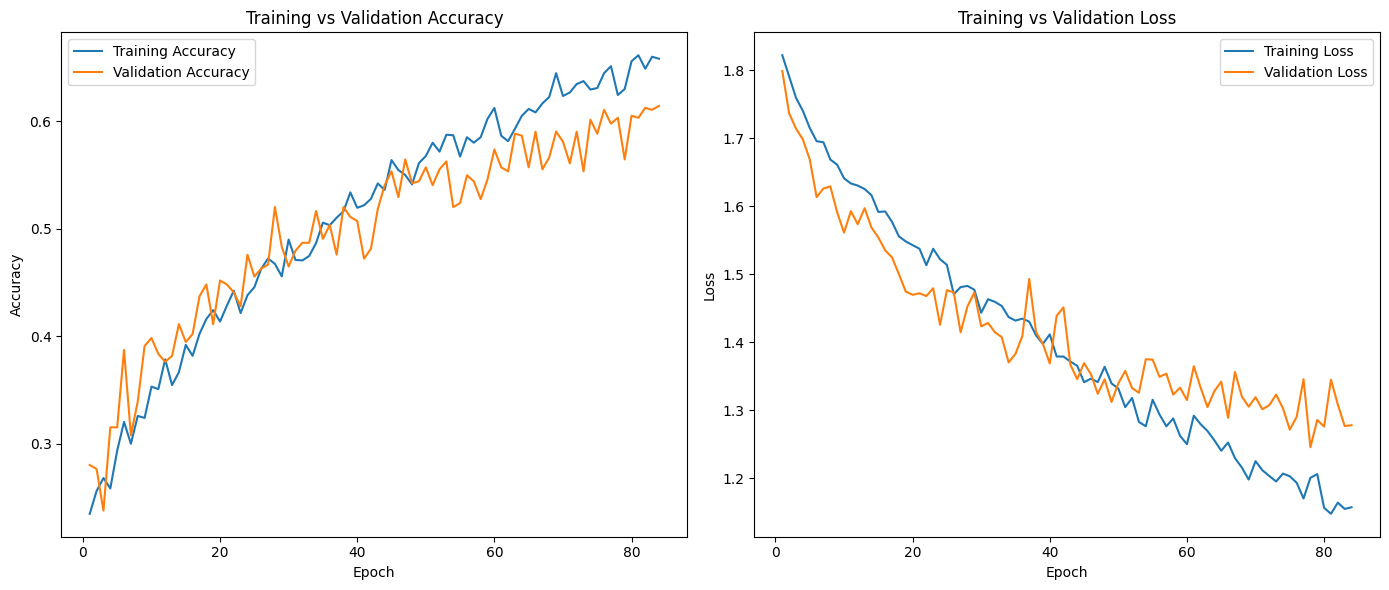

In [29]:
epochs_range = range(1, 85)

plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Predicting Potato Test
Predicts all images in the test folder and then save the results to a CSV sorted by numerical filename



In [ ]:

class_names = {
    0: "Bacteria",
    1: "Fungi",
    2: "Healthy",
    3: "Pest",
    4: "Phytopthora",
    5: "Virus"
}

def predict_folder(model, folder_path, output_csv="predictions.csv"):
    
    image_files = [f for f in os.listdir(folder_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    if not image_files:
        print(f"No images found in {folder_path}")
        return

    predictions = []
    model.eval()

    for img_file in image_files:
        try:
            img_path = os.path.join(folder_path, img_file)
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)
            
            with torch.no_grad():
                outputs = model(img_tensor)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                conf, pred = torch.max(probs, 1)

            class_id = pred.item()
            class_name = class_names.get(class_id, "Unknown")
            
            # Extract number from filename safely
            try:
                file_num = int(''.join(filter(str.isdigit, os.path.splitext(img_file)[0])))
            except:
                file_num = -1  # fallback if no digits
            
            predictions.append({
                'filename': img_file,
                'file_number': file_num,
                'class_name': class_name,
            })

            print(f"{img_file}: {class_name}")

        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            predictions.append({
                'filename': img_file,
                'file_number': -1,
                'class_name': 'Error',
            })

    df = pd.DataFrame(predictions).sort_values(by='file_number')
    df.drop(columns=['file_number'], inplace=True)
    df.to_csv(output_csv, index=False)
    print(f"\n✅ Predictions saved to {output_csv}")

    return df
    
# -------------------
# ✅ Inference and Evaluation Workflow
# -------------------
model = ViT().to(device)
model.load_state_dict(torch.load("deeplearning_vit_.pt", map_location=device)) ## Change the name of the wanted model here
model.eval()

# Predict images in a folder
predict_folder(model, "potato_test", "deeplearning_vit_predictions.csv") ##Change the name of the wanted csv name here

0.jpeg: Healthy
1.jpeg: Healthy
10.jpeg: Healthy
100.jpeg: Phytopthora
101.jpeg: Fungi
102.jpeg: Pest
103.jpeg: Fungi
104.jpeg: Fungi
105.jpeg: Fungi
106.jpeg: Pest
107.jpeg: Bacteria
108.jpeg: Healthy
109.jpeg: Fungi
11.jpeg: Healthy
110.jpeg: Pest
111.jpeg: Fungi
112.jpeg: Pest
113.jpeg: Fungi
114.jpeg: Phytopthora
115.jpeg: Fungi
116.jpeg: Pest
117.jpeg: Phytopthora
118.jpeg: Fungi
119.jpeg: Fungi
12.jpeg: Healthy
120.jpeg: Fungi
121.jpeg: Fungi
122.jpeg: Pest
123.jpeg: Fungi
124.jpeg: Fungi
125.jpeg: Phytopthora
126.jpeg: Virus
127.jpeg: Bacteria
128.jpeg: Fungi
129.jpeg: Pest
13.jpeg: Pest
130.jpeg: Fungi
131.jpeg: Fungi
132.jpeg: Fungi
133.jpeg: Fungi
134.jpeg: Fungi
135.jpeg: Phytopthora
136.jpeg: Phytopthora
137.jpeg: Fungi
138.jpeg: Fungi
139.jpeg: Fungi
14.jpeg: Bacteria
140.jpeg: Phytopthora
141.jpeg: Pest
142.jpeg: Bacteria
143.jpeg: Fungi
144.jpeg: Phytopthora
145.jpeg: Fungi
146.jpeg: Bacteria
147.jpeg: Bacteria
148.jpeg: Fungi
149.jpeg: Fungi
15.jpeg: Phytopthora
150.jpe

,filename,class_name
0,0.jpeg,Healthy
1,1.jpeg,Healthy
112,2.jpeg,Healthy
223,3.jpeg,Fungi
235,4.jpeg,Pest
...,...,...
219,296.jpeg,Pest
220,297.jpeg,Bacteria
221,298.jpeg,Pest
222,299.jpeg,Pest


# Confusion and Classification Matrix

0.jpeg: Healthy
1.jpeg: Healthy
10.jpeg: Virus
100.jpeg: Fungi
101.jpeg: Bacteria
102.jpeg: Phytopthora
103.jpeg: Healthy
104.jpeg: Virus
105.jpeg: Fungi
106.jpeg: Healthy
107.jpeg: Fungi
108.jpeg: Healthy
109.jpeg: Fungi
11.jpeg: Healthy
110.jpeg: Pest
111.jpeg: Fungi
112.jpeg: Pest
113.jpeg: Fungi
114.jpeg: Bacteria
115.jpeg: Phytopthora
116.jpeg: Virus
117.jpeg: Fungi
118.jpeg: Fungi
119.jpeg: Fungi
12.jpeg: Virus
120.jpeg: Fungi
121.jpeg: Pest
122.jpeg: Pest
123.jpeg: Fungi
124.jpeg: Fungi
125.jpeg: Fungi
126.jpeg: Virus
127.jpeg: Virus
128.jpeg: Fungi
129.jpeg: Pest
13.jpeg: Healthy
130.jpeg: Fungi
131.jpeg: Fungi
132.jpeg: Fungi
133.jpeg: Fungi
134.jpeg: Fungi
135.jpeg: Fungi
136.jpeg: Fungi
137.jpeg: Fungi
138.jpeg: Pest
139.jpeg: Fungi
14.jpeg: Virus
140.jpeg: Pest
141.jpeg: Pest
142.jpeg: Fungi
143.jpeg: Fungi
144.jpeg: Healthy
145.jpeg: Fungi
146.jpeg: Bacteria
147.jpeg: Fungi
148.jpeg: Fungi
149.jpeg: Healthy
15.jpeg: Phytopthora
150.jpeg: Fungi
151.jpeg: Fungi
152.jpeg: Fun

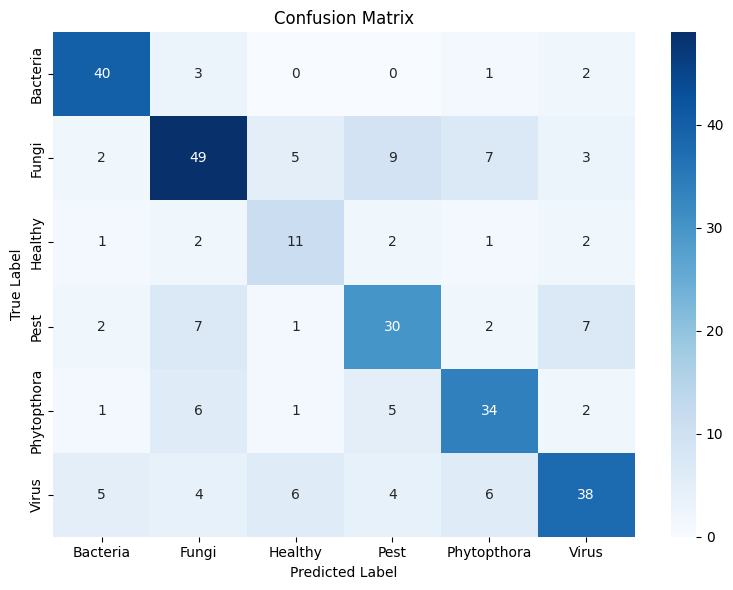


📊 Per-Class Metrics:

       Class  Precision  Recall  Specificity  F1-score  Support
    Bacteria      0.784   0.870        0.957     0.825       46
       Fungi      0.690   0.653        0.903     0.671       75
     Healthy      0.458   0.579        0.954     0.512       19
        Pest      0.600   0.612        0.921     0.606       49
 Phytopthora      0.667   0.694        0.933     0.680       49
       Virus      0.704   0.603        0.933     0.650       63
Weighted Avg      0.674   0.671        0.928     0.671      301


,Class,Precision,Recall,Specificity,F1-score,Support
0,Bacteria,0.784,0.870,0.957,0.825,46
1,Fungi,0.690,0.653,0.903,0.671,75
2,Healthy,0.458,0.579,0.954,0.512,19
3,Pest,0.600,0.612,0.921,0.606,49
4,Phytopthora,0.667,0.694,0.933,0.680,49
5,Virus,0.704,0.603,0.933,0.650,63
6,Weighted Avg,0.674,0.671,0.928,0.671,301


In [ ]:


def plot_confusion_and_metrics(y_true, y_pred, class_names, save_csv=None):
    conf_mat = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Metric calculations
    precision, recall, f1, specificity = [], [], [], []
    support = conf_mat.sum(axis=1)  # True class counts

    for i in range(len(class_names)):
        TP = conf_mat[i, i]
        FP = conf_mat[:, i].sum() - TP
        FN = conf_mat[i, :].sum() - TP
        TN = conf_mat.sum() - (TP + FP + FN)

        prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        f1s = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

        precision.append(prec)
        recall.append(rec)
        specificity.append(spec)
        f1.append(f1s)

    # Compute weighted averages
    total_support = support.sum()
    weighted_avg = lambda metric: np.sum(np.array(metric) * support) / total_support

    metrics_df = pd.DataFrame({
        "Class": class_names,
        "Precision": np.round(precision, 3),
        "Recall": np.round(recall, 3),
        "Specificity": np.round(specificity, 3),
        "F1-score": np.round(f1, 3),
        "Support": support
    })

    # Add weighted average row
    weighted_row = pd.DataFrame({
        "Class": ["Weighted Avg"],
        "Precision": [np.round(weighted_avg(precision), 3)],
        "Recall": [np.round(weighted_avg(recall), 3)],
        "Specificity": [np.round(weighted_avg(specificity), 3)],
        "F1-score": [np.round(weighted_avg(f1), 3)],
        "Support": [total_support]
    })

    metrics_df = pd.concat([metrics_df, weighted_row], ignore_index=True)

    print("\n📊 Per-Class Metrics:\n")
    print(metrics_df.to_string(index=False))

    if save_csv:
        metrics_df.to_csv(save_csv, index=False)
        print(f"\n📁 Metrics saved to {save_csv}")

    return metrics_df


# Define your class names mapping
class_names = {
    0: "Bacteria",
    1: "Fungi",
    2: "Healthy",
    3: "Pest",
    4: "Phytopthora",
    5: "Virus"
}
name_to_id = {v: k for k, v in class_names.items()}  # Inverted

# Load ground truth
gt_df = pd.read_csv("deeplearning_vit_predictions.csv")  # has: filename, class_name #change the priciton name hereee
gt_df['label_id'] = gt_df['class_name'].map(name_to_id)

# Get predictions and rename class_name to predicted_class_name to avoid clash
pred_df = predict_folder(model, "potato_test", "deeplearning_vit_predictions.csv")
pred_df = pred_df.rename(columns={"class_name": "predicted_class_name"})
pred_df['pred_id'] = pred_df['predicted_class_name'].map(name_to_id)

# Merge on filename
merged = pd.merge(gt_df, pred_df, on='filename')
print(merged.head(10))
# Calculate metrics
y_true = merged['label_id'].to_numpy()
y_pred = merged['pred_id'].to_numpy()

plot_confusion_and_metrics(y_true, y_pred, list(class_names.values()))


## Conclusion

Overall, our developed deeplearning-based approach using the Vision Transformer was able to also provide an competitive image classification model for classifying potato diseases with a validation accuracy of 61%, which also generalizes majority of potato leaf diseases. With using patching layer to patch the images and train them per patch and learning that with our ViT model, following the architechture of the traditional ViT helped us create this model achieving satisfactory results. As read from sources, ViT requires lots of datasets with 10k above as its minimum, having 4k datasets is a huge blow to the performance of our model as it reaches a stagnant accuracy at epoch 80s above. Also ViT requires lots of epochs, but with the lack of datasets it plateu at 80 epoch in which the normal ViT with 10k images reaaches to 200 and more. With our model achieving 62% accuracy from the testing, in the Classification Matrix, the precision has a 67%, and a 67% F1-Score, with that this model have achieved a satisfactory model for classifying Potato Disease from its leaves. The confusion matrix shows that the model is having troubled differentiating pest and fungi, and having the best in classifying fungi. One thing that we can improve here is in our model is maybe finding another way to get a lot of datasets to feed in our ViT, also we havent explored much using pretrained models to be added or finetuned in this model. This is our creative model especially with guide from the ViT architecture, and tweaking the layers, we are able to create this satisfactory model.